In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt
import requests

from rtree import index
from utils import *

In [2]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_drive_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [3]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes_drive.pkl')

In [4]:
f = open("../../Traffic speed bands/Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)

/home/orionstar25/Semester-8-Major-Project/Open Street Maps/Numerical Experiments/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MaximumSpeed'][i] = '80'


In [5]:
calculate_congestion(G, edges, speed_bands)

In [6]:
# Filter out all bus stop nodes
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']
node_type = nodes['highway']

# nan = 18823

# speed_camera = 2
# motorway_junction = 222
# turning_circle = 79
# crossing = 27
# turning_loop = 26
# mini_roundabout = 6
# traffic signals = 4031

for node, x, y, kind in zip(node_id, xx, yy, node_type):
    if type(kind) == float:
      idx.insert(int(node), (x,y,x,y))

In [7]:
def find_nearest_nodes(nodes, source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = []
    initial = list(idx.intersection((west, south, east, north)))   
    for node in initial:
      x = haversine_distance(nodes, node, source)
      if x <= dist:
        candidate_nodes.append(node)

    return candidate_nodes

In [8]:
def get_length_dict(sources, destinations):
    distances = dict()
  
    for source in sources:        
        for dest in destinations:
            ed = haversine_distance(nodes, source, dest)
            distances[source,dest] = ed/13.8889
       
    # sort the dictionary in ascending order using distances
    x = sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))
    return x    

## Hybrid Algorithm

## Modified Hybrid Search (n/e+1) with CH

In [9]:
def hybrid_search(G, x):
    n = len(x)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    final_route = []
    count = 0

    for i in range(n):
        source_x = nodes[nodes['osmid'] == source]['x'].values[0]
        source_y = nodes[nodes['osmid'] == source]['y'].values[0]
        dest_x = nodes[nodes['osmid'] == dest]['x'].values[0]
        dest_y = nodes[nodes['osmid'] == dest]['y'].values[0]

        url = "http://0.0.0.0:5000/route/v1/driving/{},{};{},{}".format(source_x, source_y, dest_x, dest_y)
        r = requests.get(url)
        json = r.json()
        
        if json['code'] == 'Ok':
            travel_time = json['routes'][0]['weight']
            count = count + 1
        else:
            continue        

        if travel_time < min_tt:
            min_tt = travel_time
            min_pair = x[i]

            if i < n-1:
                if travel_time < x[i+1][1]:
                    break
                else:
                    source = x[i+1][0][0]
                    dest = x[i+1][0][1]
            else:
                break
        else:
            if i < n-1:
                if min_tt < x[i+1][1]:
                    break
                else:
                    source = x[i+1][0][0]
                    dest = x[i+1][0][1]
            else:
                break

    return min_tt, count

In [10]:
def modified_hybrid_search(G, x):
    n = len(x)
    cutoff = math.floor(n/math.exp(1))
    print(cutoff)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')

    for i in range(n):
        source_x = nodes[nodes['osmid'] == source]['x'].values[0]
        source_y = nodes[nodes['osmid'] == source]['y'].values[0]
        dest_x = nodes[nodes['osmid'] == dest]['x'].values[0]
        dest_y = nodes[nodes['osmid'] == dest]['y'].values[0]

        url = "http://0.0.0.0:5000/route/v1/driving/{},{};{},{}".format(source_x, source_y, dest_x, dest_y)
        r = requests.get(url)
        json = r.json()
        
        if json['code'] == 'Ok':
            travel_time = json['routes'][0]['weight']
            
        else:
            continue 

        # have reached cutoff and didnt find optimal yet
        if i > cutoff:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]
                break
            else:
                break
        else:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]

                if i < n-1:
                    if travel_time < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break
            else:
                if i < n-1:
                    if min_tt < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break

    return min_tt, count

## Modified Hybrid Search (n/e+1) with Dijkstra

In [ ]:
def modified_hybrid_search(G, x):
    n = len(x)
    cutoff = math.floor(n/math.exp(1))
    print(cutoff)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    count = 0

    for i in range(n):
        try:
            source_x = nodes[nodes['osmid'] == source]['x'].values[0]
            source_y = nodes[nodes['osmid'] == source]['y'].values[0]
            dest_x = nodes[nodes['osmid'] == dest]['x'].values[0]
            dest_y = nodes[nodes['osmid'] == dest]['y'].values[0]
            
            url = "http://0.0.0.0:5000/route/v1/driving/{},{};{},{}".format(source_x, source_y, dest_x, dest_y)
            r = requests.get(url)
            json = r.json()
            
            travel_time = json['routes'][0]['weight']
            count = count + 1
        except nx.NetworkXUnfeasible:
            continue

        # have reached cutoff and didnt find optimal yet
        if i > cutoff:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]
                break
            else:
                break
        else:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]

                if i < n-1:
                    if travel_time < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break
            else:
                if i < n-1:
                    if min_tt < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break

    return min_tt, count

### Calculate number of queries and deviation of travel times

In [11]:
def lets_do_this():
    # get 10 random sources
    sources = []
    for i in range(50):
        r = random.randint(0,23210)
        s = nodes['osmid'].values[r]
        sources.append(s)

    # get 10 correspondig random targets
    targets = []
    for i in range(50):
        r = random.randint(0,23210)
        t = nodes['osmid'].values[r]
        targets.append(t)

    mod_hybrid_q = []
    mod_hybrid_t = []
    hybrid_q = []
    hybrid_t = []
    exhaustive_q = []
  
    for s,t in zip(sources,targets):
        orig_point = nodes[nodes['osmid'] == s].geometry.values[0]
        target_point = nodes[nodes['osmid'] == t].geometry.values[0]
        orig_xy = (orig_point.y, orig_point.x)
        target_xy = (target_point.y, target_point.x)

        # Max distance for walking is 720m (10 min * 1.2 m/s)
        # Find all nodes within 720 m from candidate sources and candidate destinations
        candidate_dest = find_nearest_nodes(nodes, target_xy, 500, idx)
        candidate_source = find_nearest_nodes(nodes, orig_xy, 500, idx)

        if len(candidate_dest) == 0:
            candidate_dest.append(ox.get_nearest_node(G, target_xy))
      
        if len(candidate_source) == 0:
            candidate_source.append(ox.get_nearest_node(G, orig_xy))

        value = len(candidate_dest) * len(candidate_source)
        print(s,t,value)
        exhaustive_q.append(value)

        euclidean = get_length_dict(candidate_source, candidate_dest)
        value1_t, value1_q = hybrid_search(G, euclidean)
        hybrid_t.append(value1_t)
        hybrid_q.append(value1_q)
        
        value2_t, value2_q = modified_hybrid_search(G, euclidean)
        mod_hybrid_t.append(value2_t)
        mod_hybrid_q.append(value2_q)

    return mod_hybrid_q, mod_hybrid_t, hybrid_q, hybrid_t, exhaustive_q

In [12]:
mod_hybrid_q, mod_hybrid_t, hybrid_q, hybrid_t, exhaustive = lets_do_this()

6164337908 245243564 320
117
1162883708 3553405959 768
282
256107697 5838853141 2886
1061
425494621 2489446245 13209
4859
5704674774 6745624807 2058
757
1268261576 244382790 2870
1055
6149379298 4726426047 3009
1106
4656699733 247428415 1740
640
2927574672 237493338 2356
866
310726797 369463512 2948
1084
258306173 2148901920 1590
584
1818895237 1366731194 3402
1251
1931970935 4736217262 1300
478
5233050789 4745204438 2520
927
1396104864 5175554775 1643
604
1396099338 246178753 396
145
3940134443 2641614678 1560
573
2085366133 425482530 9717
3574
4687625243 4598828516 912
335
1500913392 1268256228 2607
959
313933457 240407912 1540
566
3662273900 4593195725 1400
515
5841392174 5159390352 924
339
5014446271 5220397312 2960
1088
370786886 1838410507 1922
707
3231570269 388566398 960
353
6063702901 376620421 9020
3318
2467719617 1223811797 2356
866
247645344 6059478962 5096
1874
3054669476 404208950 7998
2942
378640066 4684615242 2150
790
369459060 1873971308 2679
985
4172964579 254668810 1

## Deviation between travel times calculated by hybrid and modified hybrid

In [13]:
deviations = []
for h, mod_h in zip(hybrid_t, mod_hybrid_t):
#     stddev = statistics.stdev([h, mod_h])
    stddev = mod_h - h
    deviations.append(stddev)

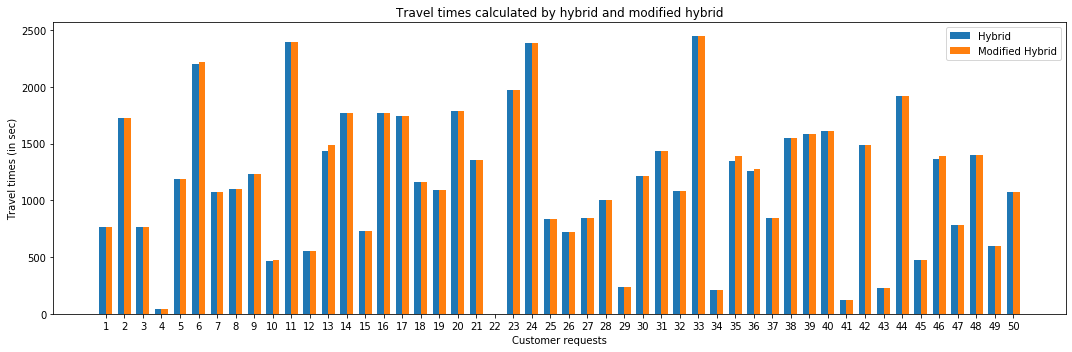

In [14]:
# Plot what hybrid gave and what modified hybrid gave
labels = [x for x in range(1,51)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, hybrid_t, width, label='Hybrid')
rects2 = ax.bar(x + width/2, mod_hybrid_t, width, label='Modified Hybrid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times (in sec)')
ax.set_xlabel('Customer requests')
ax.set_title('Travel times calculated by hybrid and modified hybrid')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

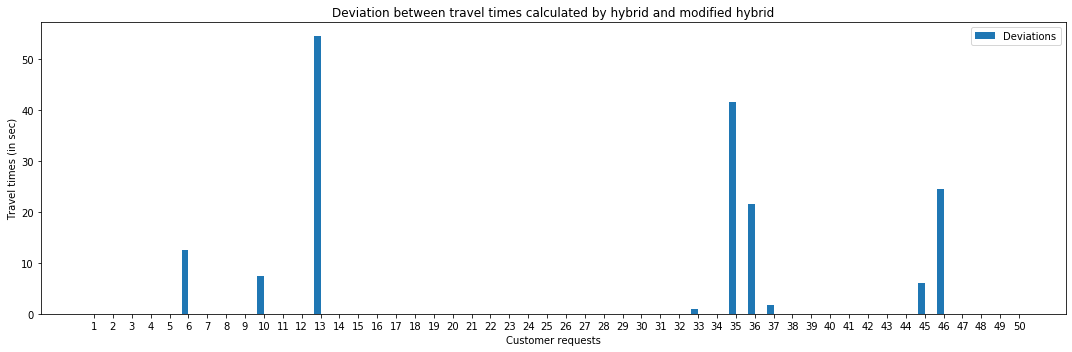

In [15]:
labels = [x for x in range(1,51)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, deviations, width, label='Deviations')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times (in sec)')
ax.set_xlabel('Customer requests')
ax.set_title('Deviation between travel times calculated by hybrid and modified hybrid')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

In [16]:
print("Average deviation in secs:", statistics.mean(deviations))

Average deviation in secs: 3.4139999999999917


## Number of queries

In [17]:
print("Number of queries")
print("Exhaustive   ||    Hybrid    ||    Modified Hybrid   ||    Saved% (Ex-Hyb)   ||    Saved% (Ex-Mod)")

hyb = []
mod = []
for e,h,m in zip(exhaustive, hybrid_q, mod_hybrid_q):
    saved_hyb = ((e-h)/e)*100
    hyb.append(saved_hyb)
    saved_mod = ((e-m)/e)*100
    mod.append(saved_mod)

    print(e, "              ", h,"              ",m, "            ",saved_hyb,"           ",saved_mod)

Number of queries
Exhaustive   ||    Hybrid    ||    Modified Hybrid   ||    Saved% (Ex-Hyb)   ||    Saved% (Ex-Mod)
320                320                119              0.0             62.81250000000001
768                768                284              0.0             63.020833333333336
2886                754                754              73.87387387387388             73.87387387387388
13209                155                155              98.82655765008707             98.82655765008707
2058                2058                759              0.0             63.11953352769679
2870                2870                1057              0.0             63.170731707317074
3009                3009                1108              0.0             63.17713526088401
1740                1740                642              0.0             63.10344827586207
2356                2356                868              0.0             63.1578947368421
2948                2935              

In [18]:
print("Average numbers of queries saved for modified hybrid%:", statistics.mean(mod))

Average numbers of queries saved for modified hybrid%: 65.27430176053835


In [19]:
print("Average numbers of queries saved for hybrid%:", statistics.mean(hyb))

Average numbers of queries saved for hybrid%: 11.168946036747064
